# Titanic: Machine Learning from Disaster

#### Import Dependencies

In [1]:
import tensorflow as tf
config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.3
tf.Session(config=config)

import keras
from keras.models import *
from keras.layers import *
from keras import optimizers
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.backend import tf as ktf
from keras.callbacks import EarlyStopping
from tqdm import tqdm

import numpy as np
import pandas as pd
from IPython.display import clear_output

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import csv
import os
from PIL import Image
%matplotlib inline
from jupyterthemes import jtplot

jtplot.style()

# jtplot.style()
%matplotlib inline

np.random.seed(1)


## Exploratory Data Analysis and Data Cleaning

In [2]:
data = pd.read_csv('train.csv')
# test_data = pd.read_csv('test.csv')

In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
data['Fare'] /= np.max(data['Fare'])
# data['Fare_cat'] = 0
# data.loc[data['Fare'] <= 7.91, 'Fare_cat'] = 0
# data.loc[(data['Fare'] > 7.91) & (data['Fare'] <= 14.454), 'Fare_cat'] = 1
# data.loc[(data['Fare'] > 14.454) & (data['Fare'] <= 31), 'Fare_cat'] = 2
# data.loc[(data['Fare'] > 31) & (data['Fare'] <= 513), 'Fare_cat'] = 3

In [11]:
data['Initial'] = data.Name.str.extract('([A-Za-z]+)\.', expand=True)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,0.014151,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,0.139136,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,0.015469,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,0.103644,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,0.015713,NaN,S,Mr


In [12]:
data.groupby('Initial')['Name'].count()

Initial
Capt          1
Col           2
Countess      1
Don           1
Dr            7
Jonkheer      1
Lady          1
Major         2
Master       40
Miss        182
Mlle          2
Mme           1
Mr          517
Mrs         125
Ms            1
Rev           6
Sir           1
Name: Name, dtype: int64

In [13]:
# there are some errors in data, let's fix them
data['Initial'].replace(['Mlle', 'Mme', 'Ms', 'Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],['Miss', 'Miss', 'Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'], inplace=True)

In [15]:
data.groupby('Initial')['Age'].mean()

Initial
Master     4.574167
Miss      21.860000
Mr        32.739609
Mrs       35.981818
Other     45.888889
Name: Age, dtype: float64

In [16]:
## Assigning the NaN Values with the Ceil values of the mean ages
data.loc[(data.Age.isnull())&(data.Initial=='Mr'),'Age']=33
data.loc[(data.Age.isnull())&(data.Initial=='Mrs'),'Age']=36
data.loc[(data.Age.isnull())&(data.Initial=='Master'),'Age']=5
data.loc[(data.Age.isnull())&(data.Initial=='Miss'),'Age']=22
data.loc[(data.Age.isnull())&(data.Initial=='Other'),'Age']=46

In [28]:
data.isnull().any() #check for nan values in age

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked       False
Initial        False
Family_Size    False
dtype: bool

In [18]:
data['Embarked'].fillna('S',inplace=True)

In [19]:
data['Age'] /= np.max(data['Age'])
# data.loc[data['Age']<=16,'Age_band']=0
# data.loc[(data['Age']>16)&(data['Age']<=32),'Age_band']=1
# data.loc[(data['Age']>32)&(data['Age']<=48),'Age_band']=2
# data.loc[(data['Age']>48)&(data['Age']<=64),'Age_band']=3
# data.loc[data['Age']>64,'Age_band']=4

In [20]:
data['Family_Size'] = data['Parch'] + data['SibSp'] + 1
data['Sex'].replace(['male','female'],[0,1],inplace=True)
data['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
data['Initial'].replace(['Mr','Mrs','Miss','Master','Other'],[0,1,2,3,4],inplace=True)

In [23]:
data['Family_Size'] /= np.max(data['Family_Size'])
data['Embarked'] /= 2
data['Initial'] /= 4


In [24]:
data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Family_Size
0,1,0,3,"Braund, Mr. Owen Harris",0,0.275,1,0,A/5 21171,0.014151,NaN,0.0,0.00,0.181818
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,0.475,1,0,PC 17599,0.139136,C85,0.5,0.25,0.181818
2,3,1,3,"Heikkinen, Miss. Laina",1,0.325,0,0,STON/O2. 3101282,0.015469,NaN,0.0,0.50,0.090909


### Preparing train and test set

In [57]:
# train, test = train_test_split(data, test_size=0.3,random_state=0,stratify=data['Survived'])

X_train = data[['Pclass', 'Sex', 'Age', 'Embarked', 'Initial','Fare', 'Family_Size']].values
X_train = X_train.astype(float)

Y_train = data['Survived'].values
# Y_train = Y_train.reshape(Y_train.shape[0])

print(X_train.shape, Y_train.shape)

(891, 7) (891,)


In [58]:
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1,)
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.legend(['train', 'val'], loc='upper left')
    plt.title(' accuracy')


    plt.subplot(1, 2, 2)
    
    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.legend(['train', 'val'], loc='upper left')
    plt.title('loss')
    plt.show()

In [131]:
def myModel(input_shape):
    inp_image = Input(input_shape)
    X = Dense(2048)(inp_image)
    X = Activation('relu')(X)
    X = Dropout(0.5)(X)
    X = Dense(2048)(X)
    X = Activation('relu')(X)
    X = Dropout(0.5)(X)
#     X = Dense(1024)(X)
#     X = Activation('relu')(X)
#     X = Dropout(0.5)(X)
    X = Dense(1, activation='sigmoid')(X)
    
    model = Model(inputs=inp_image, outputs=X)
    
    model.compile(loss='binary_crossentropy',
                 optimizer='sgd',
                 metrics=['accuracy'])
    
    return model

In [132]:
model = myModel(X_train.shape[1:])

Train on 801 samples, validate on 90 samples
Epoch 1/10
801/801 [==============================] - 3s 4ms/step - loss: 0.6438 - acc: 0.6117 - val_loss: 0.5971 - val_acc: 0.6222
Epoch 2/10
801/801 [==============================] - 1s 700us/step - loss: 0.6058 - acc: 0.6467 - val_loss: 0.5655 - val_acc: 0.7556
Epoch 3/10
801/801 [==============================] - 1s 786us/step - loss: 0.5780 - acc: 0.7054 - val_loss: 0.5381 - val_acc: 0.8000
Epoch 4/10
801/801 [==============================] - 1s 707us/step - loss: 0.5460 - acc: 0.7640 - val_loss: 0.5127 - val_acc: 0.7889
Epoch 5/10
801/801 [==============================] - 1s 725us/step - loss: 0.5237 - acc: 0.7753 - val_loss: 0.4953 - val_acc: 0.8000
Epoch 00005: early stopping


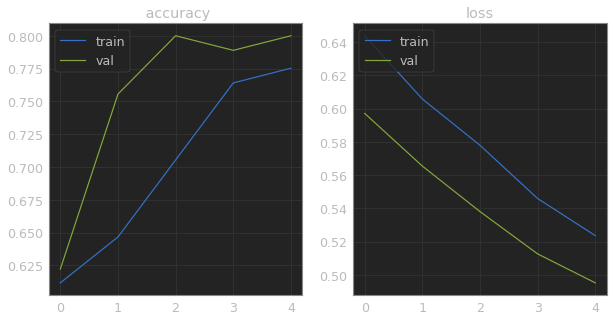

In [133]:
history = model.fit(X_train, Y_train, epochs=10, batch_size=10, verbose=1, validation_split=0.1,
                   callbacks=[EarlyStopping(monitor='val_acc', patience=2, verbose=1)])

plot_training(history)

In [99]:
test_data = pd.read_csv('test.csv')

In [100]:
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [64]:
test_data['Initial'] = test_data.Name.str.extract('([A-Za-z]+)\.', expand=True)
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mrs


In [66]:
test_data['Initial'].replace(['Col', 'Dona','Dr', 'Ms', 'Rev'], ['Other', 'Miss', 'Mr', 'Miss', 'Other'], inplace=True)
test_data.groupby('Initial')['Age'].count()

Initial
Master     17
Miss       65
Mr        184
Mrs        62
Other       4
Name: Age, dtype: int64

In [67]:
## Assigning the NaN Values with the Ceil values of the mean ages
test_data.loc[(test_data.Age.isnull())&(test_data.Initial=='Mr'),'Age']=33
test_data.loc[(test_data.Age.isnull())&(test_data.Initial=='Mrs'),'Age']=39
test_data.loc[(test_data.Age.isnull())&(test_data.Initial=='Master'),'Age']=7
test_data.loc[(test_data.Age.isnull())&(test_data.Initial=='Miss'),'Age']=22
test_data.loc[(test_data.Age.isnull())&(test_data.Initial=='Other'),'Age']=43

In [68]:
test_data['Age'] /= np.max(test_data['Age'])

# test_data['Age_band']=0
# test_data.loc[test_data['Age']<=16,'Age_band']=0
# test_data.loc[(test_data['Age']>16)&(test_data['Age']<=32),'Age_band']=1
# test_data.loc[(test_data['Age']>32)&(test_data['Age']<=48),'Age_band']=2
# test_data.loc[(test_data['Age']>48)&(test_data['Age']<=64),'Age_band']=3
# test_data.loc[test_data['Age']>64,'Age_band']=4

In [69]:
test_data['Fare'] /= np.max(test_data['Fare'])
# test_data['Fare_cat'] = 0
# test_data.loc[test_data['Fare'] <= 7.91, 'Fare_cat'] = 0
# test_data.loc[(test_data['Fare'] > 7.91) & (test_data['Fare'] <= 14.454), 'Fare_cat'] = 1
# test_data.loc[(test_data['Fare'] > 14.454) & (test_data['Fare'] <= 31), 'Fare_cat'] = 2
# test_data.loc[(test_data['Fare'] > 31) & (test_data['Fare'] <= 513), 'Fare_cat'] = 3

In [70]:
test_data['Family_Size'] = data['Parch'] + data['SibSp'] + 1
test_data['Sex'].replace(['male','female'],[0,1],inplace=True)
test_data['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
test_data['Initial'].replace(['Mr','Mrs','Miss','Master','Other'],[0,1,2,3,4],inplace=True)

In [71]:
test_data['Family_Size'] /= np.max(test_data['Family_Size'])
test_data['Embarked'] /= 2
test_data['Initial'] /= 4


In [74]:
X_test = test_data[['Pclass', 'Sex', 'Age', 'Embarked', 'Initial', 'Fare', 'Family_Size']].values
X_test.shape

(418, 7)

In [134]:
preds = model.predict(X_test)

In [135]:
Y = pd.DataFrame()
Y['PassengerId'] = test_data['PassengerId']
Y['Survived'] = preds
Y['Survived'] = np.where(Y['Survived'] > 0.5, 1, 0)
Y.to_csv('subs.csv', index=False)